In [145]:
import pyes
import elasticsearch
import json
%matplotlib inline
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
import time
import pandas as pd
import datetime

# Start time, End Time, # of fans, # of posts
fanpage 1448357445384692, 139624776093433, 100489613340306

In [146]:
es_address='140.118.207.18:9200'
def post_number (fid):
    for fid in fid:
        conn = pyes.es.ES(es_address)
        tq = pyes.query.TermQuery(field='fid', value=fid)
        tagg = pyes.aggs.TermsAgg('fid', field= 'fid',sub_aggs=[])
        DHAgg = pyes.aggs.DateHistogramAgg('day' ,field='created_time', interval='day')
        tagg.sub_aggs.append(DHAgg) 
        qsearch = pyes.query.Search(tq) 
        qsearch.agg.add(tagg) 
        result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='post')
        #print json.dumps(result.aggs,indent=3) 
        print "fid : ", result.aggs['fid']['buckets'][0]['key'], "\nStart _time : ", result.aggs['fid']['buckets'][0]['day']['buckets'][0]['key_as_string']
        print "End_time : ", result.aggs['fid']['buckets'][0]['day']['buckets'][len(result.aggs['fid']['buckets'][0]['day']['buckets'])-1]['key_as_string']
        print "Number of posts : ",  result.aggs['fid']['buckets'][0]['doc_count'], "\n"

def fan_number (fid,field):
    for fid in fid:
        conn = pyes.es.ES(es_address)
        tq = pyes.query.TermQuery(field='fid',value=fid)
        tagg = pyes.aggs.TermsAgg('likes_count', field= 'likes_count')
        qsearch = pyes.query.Search(tq) 
        qsearch.agg.add(tagg) 
        result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='fanpage')
        print "fid : ", fid, '\nNumber of fans : ', result.aggs['likes_count']['buckets'][0]['key'],'\n' 
        #print json.dumps(result.aggs,indent=3) 


In [147]:
date = []
start_time = []
end_time = []
post_number(["1448357445384692","139624776093433","100489613340306"])
    
print '\n' 

fan_number(["1448357445384692","139624776093433","100489613340306"],"fid")







fid :  1448357445384692 
Start _time :  2013-12-27T00:00:00.000Z
End_time :  2016-05-10T00:00:00.000Z
Number of posts :  378 

fid :  139624776093433 
Start _time :  2013-01-01T00:00:00.000Z
End_time :  2016-05-11T00:00:00.000Z
Number of posts :  238 

fid :  100489613340306 
Start _time :  2013-01-01T00:00:00.000Z
End_time :  2016-05-10T00:00:00.000Z
Number of posts :  1732 



fid :  1448357445384692 
Number of fans :  60673 

fid :  139624776093433 
Number of fans :  580765 

fid :  100489613340306 
Number of fans :  1025150 



# box plot against to the # of comments for each post for each fanspage

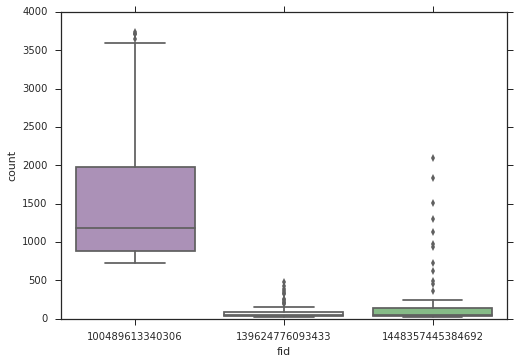

In [167]:
def boxplot_comment_number (fids,es_address,pngFilePath,outlierFilter):
    data=[]
    for fid in fids:
        conn = pyes.es.ES(es_address)
        tq = pyes.query.TermQuery(field="fid", value=fid)
        tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
        qsearch = pyes.query.Search(tq) 
        qsearch.agg.add(tagg) 
        result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')
        #print json.dumps(result.aggs,indent=2) 
        for fidpid_summary in result.aggs["pid"]["buckets"]:
            #print fidpid_summary["key"] + ',' + str(fidpid_summary["doc_count"])
            if fidpid_summary["doc_count"] < outlierFilter or outlierFilter < 0:
                data.append([fidpid_summary["doc_count"],fid,fidpid_summary["key"]])

    df=pd.DataFrame(data,columns={'count','fid','fidpid'})
    sns.set(style="ticks")
    sns_plot=sns.boxplot(x="fid", y="count", data=df, palette="PRGn")
    fig=sns_plot.get_figure()
    fig.savefig(pngFilePath)

    
es_address = '140.118.207.18:9200'
pngFilePath="plotbox_comment_number4000.png"
outlierFilter=4000

boxplot_comment_number(["1448357445384692","139624776093433","100489613340306"],es_address, pngFilePath, outlierFilter)

#print json.dumps(result_comment_numbers.aggs,indent=3) 

# Box plot (#post per month for specified page)

In [209]:
es_address = '140.118.207.18:9200'
def boxplot_comments_per_month(fid,pngFilePath,outlierFilter):
    for fid in fid:
        bq = pyes.query.BoolQuery()
        conn = pyes.es.ES(es_address)
        tq = pyes.query.TermQuery(field='fid', value=fid)
        tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
        DHAgg = pyes.aggs.DateHistogramAgg('month' ,field='created_time', interval='month',sub_aggs=[])
        DHAgg.sub_aggs.append(tagg) 
        ESR = pyes.ESRange(field="created_time", from_value="2015-01-01T00:00:00.000Z", to_value="2016-12-31T00:00:00.000Z", 
                   include_lower=True ,include_upper=False)
        rq = pyes.query.RangeQuery(qrange=ESR)
        bq.add_must(tq)
        bq.add_must(rq)
        qsearch = pyes.query.Search(bq) 
        qsearch.agg.add(DHAgg) 
        result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')
       
        data=[]
        data2=[]
        for month in result.aggs["month"]["buckets"]:
            max_data=[]
            for pid in month["pid"]["buckets"]:
                max_data.append(pid['doc_count'])
                if pid['doc_count']< outlierFilter:                    
                    monthyear=datetime.datetime.strptime(month["key_as_string"], "%Y-%m-%dT%H:%M:%S.%fZ").strftime('%y/%m')
                    data.append([pid["doc_count"],monthyear,pid["key"],month["key"]])            
            #print monthyear, '\nMax_comments : ', max(max_data),'\nMean_comments : ', round(np.mean(max_data),2),'\nMin_comments : ', min(max_data)
            data2.append([monthyear,max(max_data),round(np.mean(max_data),2), min(max_data)])
        #print json.dumps(result.aggs,indent=3) 
        df=pd.DataFrame(data,columns={'date','count','fid','pid'})
        df2 = pd.DataFrame(data2, columns={'date','Max','Mean','Min'})
        #df2.boxplot(return_type='axes')
        print df2
        print df
        sns.set(style="ticks")
        sns_plot=sns.boxplot(x="date", y="count", data=df, palette="PRGn")
        fig=sns_plot.get_figure()
        #plt.ylim(lower_bound, upper_bound)
        fig.savefig(pngFilePath)

     date   Max    Mean  Min
0   15/01   154   17.48    1
1   15/02  1291  131.96    1
2   15/03     6    3.12    1
3   15/04    20    4.11    1
4   15/05   138   12.09    1
5   15/06  2077   52.36    1
6   15/07   177   18.14    1
7   15/08  1835   75.49    1
8   15/09    95    6.94    1
9   15/10    89    9.53    1
10  15/11   235   26.57    1
11  15/12   101    8.65    1
12  16/01    22    6.86    1
13  16/02   108   14.89    1
14  16/03    61   10.24    1
15  16/04     7    2.43    1
16  16/05    28   14.80    4
     count   date                                pid            fid
0      154  15/01  1448357445384692_1603824893171279  1420070400000
1      108  15/01  1448357445384692_1602817646605337  1420070400000
2       72  15/01  1448357445384692_1595170554036713  1420070400000
3       21  15/01  1448357445384692_1587716788115423  1420070400000
4        6  15/01  1448357445384692_1599865746900527  1420070400000
5        5  15/01  1448357445384692_1600403750180060  1420070400000
6 

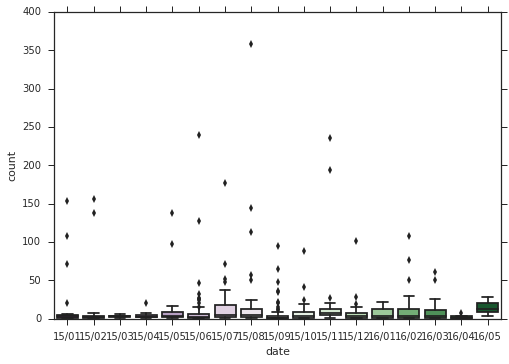

In [213]:
boxplot_comments_per_month(["1448357445384692"],"1448357445384692, boxplot_comments_per_month.png",400)

     date   Max    Mean  Min
0   15/01   326   19.25    1
1   15/02   219   11.79    1
2   15/03    25    6.79    1
3   15/04    31    8.43    1
4   15/05    76    9.52    1
5   15/06    12    3.48    1
6   15/07    28    4.76    1
7   15/08    63   14.97    1
8   15/09    19    4.42    1
9   15/10    84   14.74    1
10  15/11   415   27.19    1
11  15/12   347   16.57    1
12  16/01  9535  257.39    1
13  16/02  2284  106.13    1
14  16/03   567   38.95    1
15  16/04    92   32.33    1
16  16/05    55   15.71    1
     count   date                              pid            fid
0      326  15/01  139624776093433_771679426221295  1420070400000
1       16  15/01  139624776093433_774878579234713  1420070400000
2       12  15/01  139624776093433_772732519449319  1420070400000
3        5  15/01  139624776093433_764285256960712  1420070400000
4        4  15/01  139624776093433_773161436073094  1420070400000
5        4  15/01  139624776093433_774452405943997  1420070400000
6        3  15/0

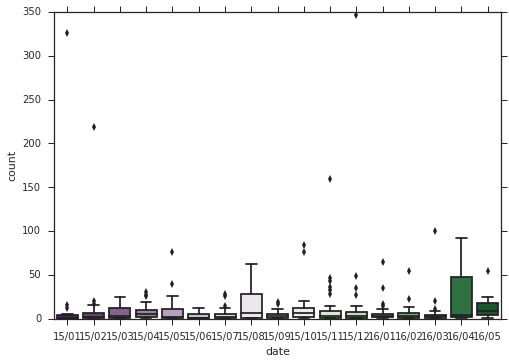

In [214]:
boxplot_comments_per_month(["139624776093433"],"139624776093433, boxplot_comments_per_month.png",400)

     date   Max    Mean  Min
0   15/01  2904  158.70    1
1   15/02  3735  143.23    1
2   15/03   858  100.27    6
3   15/04   803   64.75    1
4   15/05  2340   88.83    1
5   15/06   482   41.09    1
6   15/07   916   88.94    1
7   15/08  1358  124.32    3
8   15/09   877   81.25    4
9   15/10  3703  121.72    2
10  15/11   614   48.90    2
11  15/12  2862   96.40    1
12  16/01  1518   91.73    1
13  16/02  2100   70.42    3
14  16/03   998   63.36    2
15  16/04   174   24.17    1
16  16/05   593   43.91    1
      count   date                               pid            fid
0      1148  15/01   100489613340306_775453972510530  1420070400000
1       976  15/01   100489613340306_781594698563124  1420070400000
2       900  15/01   100489613340306_774520449270549  1420070400000
3       820  15/01   100489613340306_773345699388024  1420070400000
4       667  15/01   100489613340306_764211333634794  1420070400000
5       569  15/01   100489613340306_781662821889645  1420070400000
6 

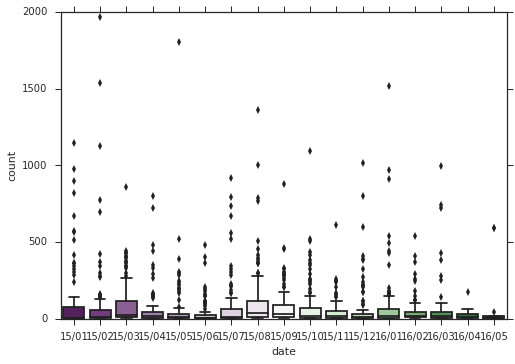

In [215]:
boxplot_comments_per_month(["100489613340306"],"100489613340306, boxplot_comments_per_month.png",2000)

In [178]:
import pyes
import json

def getUserPostFreqMatrix(row,column,fid):
    es_address = '140.118.207.18:9200'
    rc=200
    cc=200
    
    rowIndexList,colIndexList,matrix = [],[],[]
    conn=pyes.es.ES(es_address)
    tq = pyes.query.TermQuery(field="fid", value=fid)

    tagg = pyes.aggs.TermsAgg(row, field= row, sub_aggs=[]) 
    tagg1 = pyes.aggs.TermsAgg(column, field= column)  
    tagg.sub_aggs.append(tagg1) 

    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(tagg)

    rs = conn.search(query=qsearch, indices='facebook_nested' ,type="comment" )
    print json.dumps(rs.aggs,indent=3)
    rowcount=0
    colcount=0
    for user in rs.aggs[row]['buckets']:
        if user['key']!="" and user['key'] not in rowIndexList and rowcount<rc:
            rowIndexList.append(user['key'])
            rowcount=rowcount+1

        for post in user[column]['buckets']:
            if post['key'] not in colIndexList and colcount<cc:
                colIndexList.append(post['key'])
                colcount=colcount+1

    for i in range(0,len(rowIndexList)):
        matrix.append([0.0]*len(colIndexList))

    for user in rs.aggs[row]['buckets']:
        if user["key"] in rowIndexList:
            for post in user[column]['buckets']:
                if post['key'] in colIndexList:
                    matrix[rowIndexList.index(user['key'])][colIndexList.index(post['key'])]= float(post['doc_count'])
    
    
    return {"data":matrix,"col":colIndexList,"row":rowIndexList}

In [179]:
row="from.id"
column="fid_pid"
fid="100489613340306"
result = getUserPostFreqMatrix(row,column,fid)

NoServerAvailable: list index out of range

In [ ]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=result["data"],
                 columns=result["col"])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)